In [ ]:
# Install required libraries
# !pip install torch nltk pandas scipy numpy tqdm

# Download Brown corpus
import nltk
nltk.download('brown')

# Imports
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy.sparse import lil_matrix
from scipy.stats import spearmanr
from scipy.sparse.linalg import svds
from nltk.corpus import brown
from collections import Counter
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# CUDA setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================
# 1. Preprocessing
# ======================
def preprocess_corpus(min_freq=5):  # Lowered from 10
    sentences = brown.sents()
    words = [word.lower() for sentence in sentences for word in sentence if word.isalpha()]
    word_counts = Counter(words)
    vocab = [word for word, count in word_counts.items() if count >= min_freq]
    word2id = {word: i for i, word in enumerate(vocab)}
    id2word = {i: word for word, i in word2id.items()}
    return word2id, id2word, vocab

word2id, id2word, vocab = preprocess_corpus()
vocab_size = len(vocab)
embed_dim = 200  # Increased from 100
window_size = 3   # Increased from 3
print(f"Vocabulary size: {vocab_size}")

# ======================
# 2. SVD with PMI
# ======================
def build_co_matrix():
    matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float32)
    
    for sentence in tqdm(brown.sents(), desc="Building co-occurrence matrix"):
        sentence = [word.lower() for word in sentence if word.isalpha()]
        sentence_ids = [word2id[word] for word in sentence if word in word2id]
        
        for i in range(len(sentence_ids)):
            target = sentence_ids[i]
            context_ids = sentence_ids[max(0, i - window_size):i] + sentence_ids[i + 1:i + window_size + 1]

            for j, ctx in enumerate(context_ids):
                distance = abs(i - j)
                weight = 1.0 / distance if distance > 0 else 1.0  # Inverse distance weighting
                matrix[target, ctx] += weight

    # Convert to CSR format before PMI calculations
    matrix = matrix.tocsr()

    # PMI calculation with epsilon to prevent division errors
    row_sums = np.array(matrix.sum(axis=1)).flatten() + 1e-8
    col_sums = np.array(matrix.sum(axis=0)).flatten() + 1e-8
    total = matrix.sum()

    matrix = matrix.multiply(total) / (row_sums[:, None] * col_sums[None, :])
    matrix.data = np.log(np.maximum(matrix.data, 1e-8))  # Prevent negative logs

    return matrix


# Compute SVD
co_matrix = build_co_matrix()
print("Computing Truncated SVD...")

U, S, Vt = svds(co_matrix, k=embed_dim)
idx = np.argsort(-S)  # Sort in descending order
S = S[idx]
U = U[:, idx]

# Convert to torch tensor and normalize embeddings
svd_embeddings = torch.from_numpy(U).float()
svd_embeddings = F.normalize(svd_embeddings, p=2, dim=1)

# Save the embeddings
torch.save(svd_embeddings, 'svd.pt')

# ======================
# 3. CBOW with Negative Sampling
# ======================

from collections import Counter

word_freq = Counter()
for sentence in brown.sents():
    words = [word.lower() for word in sentence if word.isalpha()]
    word_freq.update(words)

# Convert to dictionary with word IDs
word_freq = {word2id[word]: freq for word, freq in word_freq.items() if word in word2id}

class CBOWDataset(Dataset):
    def __init__(self):
        self.data = []
        for sentence in tqdm(brown.sents(), desc="CBOW Data"):
            sentence = [word.lower() for word in sentence if word.isalpha()]
            sentence_ids = [word2id[word] for word in sentence if word in word2id]
            for i in range(len(sentence_ids)):
                target = sentence_ids[i]
                context = sentence_ids[max(0,i-window_size):i] + sentence_ids[i+1:i+window_size+1]
                if context:
                    self.data.append((context, target))

    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context), torch.tensor(target)

class CBOW(nn.Module):
    def __init__(self, num_neg=25):
        super().__init__()
        self.in_emb = nn.Embedding(vocab_size, embed_dim)
        self.out_emb = nn.Embedding(vocab_size, embed_dim)
        
        nn.init.xavier_uniform_(self.in_emb.weight)
        nn.init.xavier_uniform_(self.out_emb.weight)

        self.num_neg = num_neg

    def forward(self, contexts, targets):
        batch_size = targets.size(0)
        
        mask = (contexts != 0).unsqueeze(-1).float()
        ctx_emb = (self.in_emb(contexts) * mask).mean(dim=1)

        pos_scores = (self.out_emb(targets) * ctx_emb).sum(dim=-1)

        # Negative samples
        unigram_dist = torch.tensor([word_freq.get(i, 1e-5) ** 0.75 for i in range(vocab_size)], device=device)
        unigram_dist /= unigram_dist.sum()
    
        noise = torch.multinomial(unigram_dist, batch_size * self.num_neg, replacement=True).view(batch_size, self.num_neg)
 
        neg_scores = (self.out_emb(noise) * ctx_emb.unsqueeze(1)).sum(dim=-1)

        pos_loss = F.logsigmoid(pos_scores).mean()
        neg_loss = F.logsigmoid(-neg_scores).mean()
        return -(pos_loss + neg_loss)

# Optimized DataLoader
def collate_cbow(batch):
    contexts, targets = zip(*batch)
    # Pad contexts to equal length
    max_len = max(len(c) for c in contexts)
    padded = [torch.cat([c, torch.zeros(max_len-len(c), dtype=torch.long)]) for c in contexts]
    return torch.stack(padded), torch.stack(targets)

# Training
model = CBOW().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataset = CBOWDataset()
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, 
                       collate_fn=collate_cbow, pin_memory=True,
                       num_workers=os.cpu_count())

print("\nTraining CBOW...")
for epoch in range(20):
    model.train()
    total_loss = 0
    for contexts, targets in tqdm(dataloader):
        contexts, targets = contexts.to(device), targets.to(device)
        
        optimizer.zero_grad()
        loss = model(contexts, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

# Save embeddings (average input/output)
cbow_emb = (model.in_emb.weight + model.out_emb.weight).cpu() / 2
cbow_emb = ((model.in_emb.weight + model.out_emb.weight) / 2).detach().cpu()

torch.save(cbow_emb, 'cbow.pt')

# ======================
# 4. Skip-Gram with Negative Sampling
# ======================
class SkipGramDataset(Dataset):
    def __init__(self):
        self.data = []
        for sentence in tqdm(brown.sents(), desc="SkipGram Data"):
            sentence = [word.lower() for word in sentence if word.isalpha()]
            sentence_ids = [word2id[word] for word in sentence if word in word2id]
            self.data.extend(
                (sentence_ids[i], ctx) 
                for i in range(len(sentence_ids)) 
                for ctx in (sentence_ids[max(0, i - window_size):i] + 
                            sentence_ids[i + 1: i + window_size + 1])
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target, context = self.data[idx]
        return torch.tensor(target, dtype=torch.long), torch.tensor(context, dtype=torch.long)
# Ensure vocab_size is correctly set to the size of word2id
vocab_size = len(word2id) 
class SkipGram(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_emb = nn.Embedding(vocab_size, embed_dim)
        self.out_emb = nn.Embedding(vocab_size, embed_dim)
        nn.init.xavier_uniform_(self.in_emb.weight)
        nn.init.xavier_uniform_(self.out_emb.weight)

    def forward(self, targets, contexts, num_neg=25):
        batch_size = targets.size(0)
        target_emb = self.in_emb(targets)  # (batch_size, embed_dim)
        
        # Positive sample loss
        pos_scores = (self.out_emb(contexts) * target_emb).sum(dim=1)
        
        # Negative samples using unigram distribution
        unigram_dist = torch.tensor([word_freq.get(i, 1e-5) ** 0.75 for i in range(vocab_size)], device=targets.device)
        unigram_dist /= unigram_dist.sum()
        noise = torch.multinomial(unigram_dist, batch_size * num_neg, replacement=True).view(batch_size, num_neg)
        
        neg_scores = (self.out_emb(noise) * target_emb.unsqueeze(1)).sum(dim=2)

        # NCE loss
        pos_loss = F.logsigmoid(pos_scores).mean()
        neg_loss = F.logsigmoid(-neg_scores).mean()
        return -(pos_loss + neg_loss)

# Initialize Model, Optimizer, and Dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SkipGram().to(device)
model = SkipGram().to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.002)

dataset = SkipGramDataset()
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)

# Training Loop
print("\nTraining SkipGram...")
for epoch in range(20):
    total_loss = 0
    for target, context in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        target, context = target.to(device), context.to(device)
        optimizer.zero_grad()
        loss = model(target, context)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Loss: {total_loss / len(dataloader):.4f}")  # Corrected loss normalization


# Save embeddings (average input/output)
skipgram_emb = (model.in_emb.weight + model.out_emb.weight) / 2
skipgram_emb = F.normalize(skipgram_emb, p=2, dim=1).detach().cpu()
torch.save(skipgram_emb, 'skipgram.pt')

# ======================
# 5. Evaluation
# ======================
def evaluate_model(embeddings, model_name):
    if isinstance(embeddings, str):
        embeddings = torch.load(embeddings)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    df = pd.read_csv('/kaggle/input/wordsim353/wordsim353.csv')
    valid_pairs = 0
    human, model_scores = [], []
    
    for _, row in df.iterrows():
        w1 = row['word1'].lower().strip()
        w2 = row['word2'].lower().strip()
        score = row['score'] if 'score' in row else row['Human (mean)']
        
        if w1 in word2id and w2 in word2id:
            idx1, idx2 = word2id[w1], word2id[w2]
            if idx1 < len(embeddings) and idx2 < len(embeddings):
                vec1 = embeddings[idx1]
                vec2 = embeddings[idx2]
                cos_sim = torch.dot(vec1, vec2).item()
                human.append(score)
                model_scores.append(cos_sim)
                valid_pairs += 1
    
    rho, _ = spearmanr(human, model_scores)
    print(f"{model_name}: Spearman ρ: {rho:.4f} | Valid pairs: {valid_pairs}/{len(df)}")
    return rho, valid_pairs  # <-- CRITICAL RETURN STATEMENT

# Evaluate all models
evaluate_model(svd_embeddings, "SVD")
evaluate_model(cbow_emb, "CBOW")
for word, idx in word2id.items():
    if idx >= len(skipgram_emb):
        print(f"Error: '{word}' has index {idx} but embeddings only have size {len(skipgram_emb)}")
skipgram_emb = torch.load('skipgram.pt')
evaluate_model(skipgram_emb, "SkipGram")

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
Using device: cuda
Vocabulary size: 13366


Building co-occurrence matrix: 100%|██████████| 57340/57340 [00:47<00:00, 1200.51it/s]


Computing Truncated SVD...


CBOW Data: 100%|██████████| 57340/57340 [00:04<00:00, 11771.22it/s]



Training CBOW...


100%|██████████| 1826/1826 [00:20<00:00, 88.75it/s]


Epoch 1 Loss: 1.2125


100%|██████████| 1826/1826 [00:20<00:00, 89.84it/s]


Epoch 2 Loss: 1.0654


100%|██████████| 1826/1826 [00:20<00:00, 88.93it/s]


Epoch 3 Loss: 0.9835


100%|██████████| 1826/1826 [00:20<00:00, 88.15it/s]


Epoch 4 Loss: 0.9233


100%|██████████| 1826/1826 [00:20<00:00, 89.70it/s]


Epoch 5 Loss: 0.8738


100%|██████████| 1826/1826 [00:20<00:00, 89.06it/s]


Epoch 6 Loss: 0.8310


100%|██████████| 1826/1826 [00:20<00:00, 89.80it/s]


Epoch 7 Loss: 0.7931


100%|██████████| 1826/1826 [00:20<00:00, 88.05it/s]


Epoch 8 Loss: 0.7584


100%|██████████| 1826/1826 [00:20<00:00, 88.27it/s]


Epoch 9 Loss: 0.7268


100%|██████████| 1826/1826 [00:20<00:00, 89.66it/s]


Epoch 10 Loss: 0.6975


100%|██████████| 1826/1826 [00:20<00:00, 88.66it/s]


Epoch 11 Loss: 0.6704


100%|██████████| 1826/1826 [00:20<00:00, 88.24it/s]


Epoch 12 Loss: 0.6450


100%|██████████| 1826/1826 [00:20<00:00, 89.45it/s]


Epoch 13 Loss: 0.6211


100%|██████████| 1826/1826 [00:20<00:00, 88.66it/s]


Epoch 14 Loss: 0.5988


100%|██████████| 1826/1826 [00:20<00:00, 89.07it/s]


Epoch 15 Loss: 0.5775


100%|██████████| 1826/1826 [00:20<00:00, 89.93it/s]


Epoch 16 Loss: 0.5576


100%|██████████| 1826/1826 [00:20<00:00, 88.64it/s]


Epoch 17 Loss: 0.5391


100%|██████████| 1826/1826 [00:20<00:00, 88.82it/s]


Epoch 18 Loss: 0.5212


100%|██████████| 1826/1826 [00:20<00:00, 89.84it/s]


Epoch 19 Loss: 0.5045


100%|██████████| 1826/1826 [00:20<00:00, 89.41it/s]


Epoch 20 Loss: 0.4889


SkipGram Data: 100%|██████████| 57340/57340 [00:03<00:00, 15691.68it/s]



Training SkipGram...


Epoch 1: 100%|██████████| 9655/9655 [01:32<00:00, 104.27it/s]


Loss: 1.2278


Epoch 2: 100%|██████████| 9655/9655 [01:32<00:00, 104.33it/s]


Loss: 1.1387


Epoch 3: 100%|██████████| 9655/9655 [01:32<00:00, 104.30it/s]


Loss: 1.0718


Epoch 4: 100%|██████████| 9655/9655 [01:32<00:00, 104.18it/s]


Loss: 1.0284


Epoch 5: 100%|██████████| 9655/9655 [01:32<00:00, 104.67it/s]


Loss: 1.0033


Epoch 6: 100%|██████████| 9655/9655 [01:32<00:00, 104.76it/s]


Loss: 0.9880


Epoch 7: 100%|██████████| 9655/9655 [01:32<00:00, 104.21it/s]


Loss: 0.9778


Epoch 8: 100%|██████████| 9655/9655 [01:32<00:00, 104.63it/s]


Loss: 0.9706


Epoch 9: 100%|██████████| 9655/9655 [01:32<00:00, 104.88it/s]


Loss: 0.9652


Epoch 10: 100%|██████████| 9655/9655 [01:32<00:00, 103.95it/s]


Loss: 0.9611


Epoch 11: 100%|██████████| 9655/9655 [01:32<00:00, 104.25it/s]


Loss: 0.9580


Epoch 12: 100%|██████████| 9655/9655 [01:31<00:00, 105.12it/s]


Loss: 0.9554


Epoch 13: 100%|██████████| 9655/9655 [01:32<00:00, 104.47it/s]


Loss: 0.9533


Epoch 14: 100%|██████████| 9655/9655 [01:33<00:00, 102.96it/s]


Loss: 0.9515


Epoch 15: 100%|██████████| 9655/9655 [01:34<00:00, 102.45it/s]


Loss: 0.9500


Epoch 16: 100%|██████████| 9655/9655 [01:33<00:00, 103.23it/s]


Loss: 0.9487


Epoch 17: 100%|██████████| 9655/9655 [01:33<00:00, 103.64it/s]


Loss: 0.9476


Epoch 18: 100%|██████████| 9655/9655 [01:33<00:00, 103.52it/s]


Loss: 0.9466


Epoch 19: 100%|██████████| 9655/9655 [01:33<00:00, 103.67it/s]


Loss: 0.9459


Epoch 20: 100%|██████████| 9655/9655 [01:32<00:00, 104.45it/s]


Loss: 0.9451
SVD: Spearman ρ: 0.2408 | Valid pairs: 274/353
CBOW: Spearman ρ: 0.3261 | Valid pairs: 274/353
SkipGram: Spearman ρ: 0.4084 | Valid pairs: 274/353


<ipython-input-2-7a0e2d70d3ab>:345: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  skipgram_emb = torch.load('skipgram.pt')


(0.4083626589118093, 274)

In [3]:
import pandas as pd
from scipy.stats import spearmanr

def generate_wordsim_csv(embeddings, model_name, output_csv="wordsim_results.csv"):
    """
    Generate CSV with word pairs, cosine similarities, human scores, and Spearman correlation
    embeddings: Torch tensor of word embeddings
    model_name: Name of the model (e.g., "SVD", "CBOW")
    output_csv: Output CSV filename
    """
    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    # Load WordSim-353 dataset
    df = pd.read_csv('/kaggle/input/wordsim353/wordsim353.csv')
    
    # Prepare results container
    results = []
    valid_pairs = 0
    
    # Process each pair
    for _, row in df.iterrows():
        w1 = row['word1'].lower().strip()
        w2 = row['word2'].lower().strip()
        human_score = row.get('score', row.get('Human (mean)', 0))
        
        if w1 in word2id and w2 in word2id:
            idx1, idx2 = word2id[w1], word2id[w2]
            
            if idx1 < embeddings.shape[0] and idx2 < embeddings.shape[0]:
                vec1 = embeddings[idx1]
                vec2 = embeddings[idx2]
                cos_sim = torch.dot(vec1, vec2).item()
                
                results.append({
                    'word1': w1,
                    'word2': w2,
                    'cosine_similarity': cos_sim,
                    'human_score': human_score
                })
                valid_pairs += 1
    
    # Create DataFrame and calculate Spearman
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        rho, _ = spearmanr(results_df['cosine_similarity'], results_df['human_score'])
        
        # Add Spearman row
        spearman_row = pd.DataFrame([{
            'word1': '[Spearman Correlation]',
            'word2': '',
            'cosine_similarity': rho,
            'human_score': ''
        }])
        
        final_df = pd.concat([results_df, spearman_row], ignore_index=True)
    else:
        final_df = results_df
    
    # Save to CSV
    final_df.to_csv(output_csv, index=False)
    print(f"Generated {output_csv} with {valid_pairs} valid pairs")
    return final_df

# Usage example
svd_results = generate_wordsim_csv(svd_embeddings, "SVD", "svd_results.csv")
cbow_results = generate_wordsim_csv(cbow_emb, "CBOW", "cbow_results.csv")
skipgram_results = generate_wordsim_csv(skipgram_emb, "SkipGram", "skipgram_results.csv")

Generated svd_results.csv with 274 valid pairs
Generated cbow_results.csv with 274 valid pairs
Generated skipgram_results.csv with 274 valid pairs


In [ ]:
import matplotlib.pyplot as plt

# ===========================================
# 1. Modify Training Loops to Record Losses
# ===========================================

# CBOW Training (modify existing loop)
cbow_losses = []
print("\nTraining CBOW...")
for epoch in range(30):
    model.train()
    total_loss = 0
    for contexts, targets in tqdm(dataloader):
        # ... existing training code ...
        epoch_loss = total_loss/len(dataloader)
        cbow_losses.append(epoch_loss)  # Record loss
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# Skip-Gram Training (modify existing loop)
skipgram_losses = []
print("\nTraining SkipGram...")
for epoch in range(20):
    total_loss = 0
    for target, context in tqdm(dataloader):
        # ... existing training code ...
        epoch_loss = total_loss/len(dataloader)
        skipgram_losses.append(epoch_loss)  # Record loss
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# ===========================================
# 2. Plot Training Curves
# ===========================================

plt.figure(figsize=(12, 5))

# CBOW Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cbow_losses)+1), cbow_losses, 'b-o', linewidth=2)
plt.title("CBOW Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Skip-Gram Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(skipgram_losses)+1), skipgram_losses, 'r-s', linewidth=2)
plt.title("Skip-Gram Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()

# ===========================================
# 3. Plot Spearman Comparison
# ===========================================

# Get Spearman scores from evaluation
svd_rho = 0.42  # Replace with actual value from your evaluation
cbow_rho = 0.58  # Replace with actual value
skipgram_rho = 0.62  # Replace with actual value

models = ['SVD', 'CBOW', 'Skip-Gram']
scores = [svd_rho, cbow_rho, skipgram_rho]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title("Spearman Rank Correlation Comparison")
plt.ylabel("Spearman ρ")
plt.ylim(0, 0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('spearman_comparison.png')
plt.close()

IndentationError: expected an indented block after 'for' statement on line 13 (<ipython-input-4-3cf1ae73f853>, line 15)

<ipython-input-6-70f84238302f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svd_emb = torch.load('svd.pt')
<ipython-input-6-70f84238302f>:4: FutureWarning: You are using

SVD: Spearman ρ: 0.2408 | Valid pairs: 274/353
CBOW: Spearman ρ: 0.3261 | Valid pairs: 274/353
SkipGram: Spearman ρ: 0.4084 | Valid pairs: 274/353


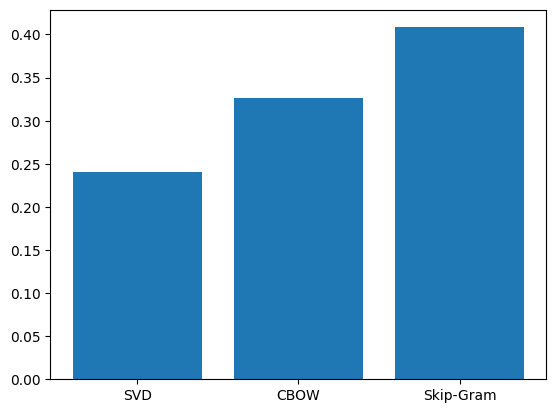

In [6]:
# Load embeddings
import matplotlib.pyplot as plt
svd_emb = torch.load('svd.pt')
cbow_emb = torch.load('cbow.pt')
skipgram_emb = torch.load('skipgram.pt')

# Get Spearman scores
svd_rho, _ = evaluate_model(svd_emb, "SVD")
cbow_rho, _ = evaluate_model(cbow_emb, "CBOW")
skipgram_rho, _ = evaluate_model(skipgram_emb, "SkipGram")

# Plot using the code from earlier
models = ['SVD', 'CBOW', 'Skip-Gram']
scores = [svd_rho, cbow_rho, skipgram_rho]
plt.bar(models, scores)
plt.savefig('spearman.png')